In [51]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import yfinance as yf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from typing import Tuple, List

import warnings
warnings.filterwarnings("ignore")

In [2]:
# constants
TRAIN_START = '2006-01-01'
TRAIN_END = '2016-01-01'
TEST_START = '2014-01-01'
TEST_END = '2024-09-01'

In [3]:
snp500 = pd.read_csv('../../src/data/snp500.csv')
sectors = snp500.groupby('sector')
sector_tickers = {sector[0]: sector[1]['ticker'].tolist() for sector in sectors}

In [4]:
prices = yf.download(snp500['ticker'].tolist(), start=TRAIN_START, end=TRAIN_END)['Adj Close']

# drop tickers with missing data
prices = prices.dropna(axis=1)

for sector, ticker in sector_tickers.items():
    sector_tickers[sector] = [ticker for ticker in sector_tickers[sector] if ticker in prices.columns]

[*********************100%%**********************]  500 of 500 completed

24 Failed downloads:
['DOW', 'SOLV', 'KVUE', 'CTVA', 'LW', 'GEHC', 'INVH', 'MRNA', 'CRWD', 'VICI', 'FTV', 'GEV', 'FOX', 'DAY', 'CEG', 'VLTO', 'FOXA', 'HWM', 'VST', 'OTIS', 'UBER', 'ABNB', 'IR', 'CARR']: Exception("%ticker%: Data doesn't exist for startDate = 1136091600, endDate = 1451624400")


In [5]:
# generate potential cointegrated pairs
pairs = []
for tickers in sector_tickers.values():
    for i in range(len(tickers)):
        for j in range(i+1, len(tickers)):
            pairs.append([tickers[i], tickers[j]])

In [12]:
# johansen cointegration test
def johansen_test(data: pd.DataFrame) -> Tuple[bool, dict]:
    # find optimal lag using AIC
    model = VAR(data)
    optimal_lag = model.select_order(15).aic
    
    # test for cointegration
    try:
        johansen_test = coint_johansen(data, det_order=0, k_ar_diff=optimal_lag)
        trace_stat = johansen_test.lr1[0]
        crit_val = johansen_test.cvt[0][1] # use 0.05 significance level
        coint_vector = johansen_test.evec[:,0]
    
        is_cointegrated = trace_stat > crit_val
        results = {
            'tickers': data.columns.tolist(),
            'coint_vector': coint_vector,
        }
    except:
        is_cointegrated = False
        results = {}
    
    return is_cointegrated, results

In [13]:
# walk-forward test for cointegration
# 2 years of in sample training data, 6 months of out of sample testing data
IN_SAMPLE_PERIOD = 504 # 2 years
OUT_OF_SAMPLE_PERIOD = 126 # 6 months

num_tests = (len(prices) - IN_SAMPLE_PERIOD) // OUT_OF_SAMPLE_PERIOD
coint_results = {}

for i, n in enumerate(range(IN_SAMPLE_PERIOD, len(prices)-OUT_OF_SAMPLE_PERIOD, OUT_OF_SAMPLE_PERIOD)):
    training_data = prices.iloc[n-IN_SAMPLE_PERIOD:n]
    print(f'Running test {i+1}/{num_tests}')
    
    for pair in pairs:
        is_cointegrated, _ = johansen_test(training_data[pair])
        if is_cointegrated:
            coint_results[tuple(pair)] = coint_results.get(tuple(pair), 0) + 1

Running test 1/15
Running test 2/15
Running test 3/15
Running test 4/15
Running test 5/15
Running test 6/15
Running test 7/15
Running test 8/15
Running test 9/15
Running test 10/15
Running test 11/15
Running test 12/15
Running test 13/15
Running test 14/15
Running test 15/15


In [14]:
# filter out pair with most cointegration occurrences
vals = list(coint_results.values())
keys = list(coint_results.keys())
max_pair = list(keys[vals.index(np.max(vals))])

In [83]:
def plot_spread(
    spread: pd.Series,
    pair: List[str],
    upper_threshold: float,
    lower_threshold: float,
    mean: float,
    title: str=None
) -> None:
    plt.figure(figsize=(12, 6))
    plt.plot(spread)
    plt.axhline(mean, color='black', linestyle='--', label='Exit Positions')
    plt.axhline(
        upper_threshold, color='red', linestyle='--', label=f'Buy {pair[1]} and Sell {pair[0]}'
    )
    plt.axhline(
        lower_threshold, color='green', linestyle='--', label=f'Buy {pair[0]} and Sell {pair[1]}'
    )
    if title:
        plt.title(title)
    else:
        plt.title(
            f'Cointegration Spread between {pair[0]} and {pair[1]}'
        )
    plt.xlabel('Date')
    plt.ylabel(rf'$Y_1 - \lambda Y_2$')
    plt.legend()
    plt.show()

In [84]:
# download testing data
test_prices = yf.download(max_pair, start=TEST_START, end=TEST_END)['Adj Close']

[*********************100%%**********************]  2 of 2 completed


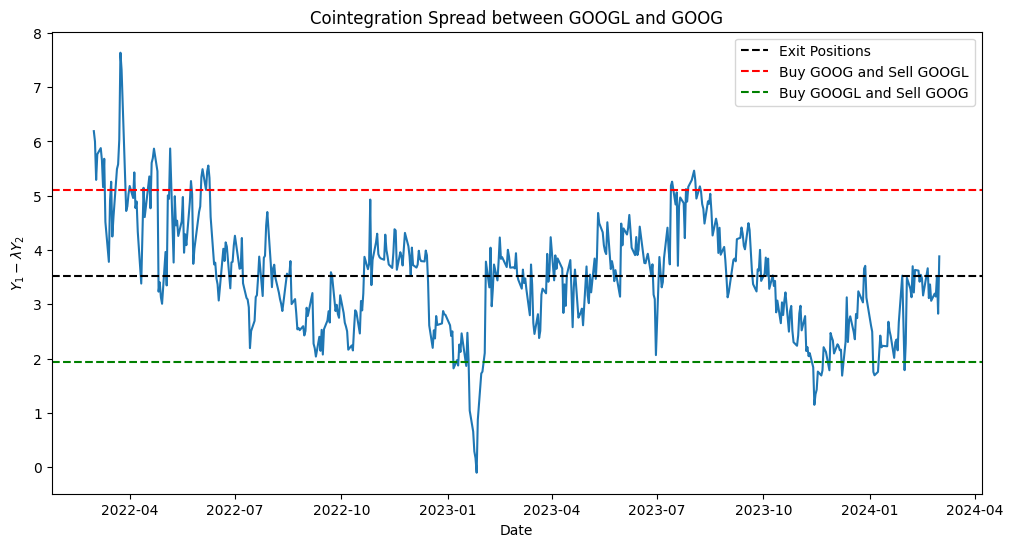

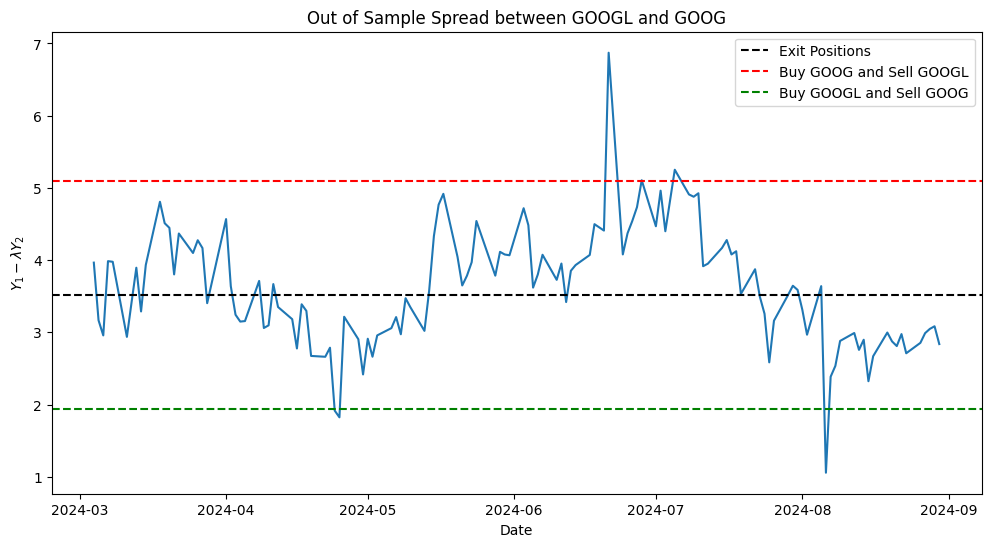

In [85]:
# plot an example spread
n = len(test_prices)-OUT_OF_SAMPLE_PERIOD
in_sample_data = test_prices[max_pair].iloc[
    n-IN_SAMPLE_PERIOD : n
]
out_sample_data = test_prices[max_pair].iloc[n : n+OUT_OF_SAMPLE_PERIOD]

is_cointegrated, res = johansen_test(in_sample_data)

if is_cointegrated:
    # plot spread and thresholds using in sample data
    spread = in_sample_data.dot(res['coint_vector'])
    mean = spread.mean()
    std = spread.std()
    upper_threshold = mean + 1.5*std
    lower_threshold = mean - 1.5*std
    plot_spread(
        spread,
        res['tickers'],
        upper_threshold,
        lower_threshold,
        mean
    )

    # plot spread and thresholds using out of sample data
    out_sample_spread = out_sample_data.dot(res['coint_vector'])
    plot_spread(
        out_sample_spread,
        res['tickers'],
        upper_threshold,
        lower_threshold,
        mean,
        title=f'Out of Sample Spread between {res["tickers"][0]} and {res["tickers"][1]}'
    )

In [19]:
def calculate_returns(
    starting_cash: float,
    stock_1_signals: List[int],
    stock_2_signals: List[int],
    stock_1_prices: pd.Series,
    stock_2_prices: pd.Series,
    transaction_cost: float=0
) -> Tuple[List[float], List[float]]:
    stock_1_shares, stock_2_shares = 0, 0
    portfolio_history = []
    cash = starting_cash
    
    for i in range(len(stock_1_signals)):
        stock_1_price = stock_1_prices[i]
        stock_2_price = stock_2_prices[i]
        
        # record any transactions
        if stock_1_signals[i] == 1 and stock_1_shares == 0:
            # buy stock 1
            stock_1_shares += (cash - transaction_cost) // stock_1_price
            cash = cash - stock_1_shares*stock_1_price - transaction_cost
        elif stock_2_signals[i] == 1 and stock_2_shares == 0:
            # buy stock 2
            stock_2_shares += (cash - transaction_cost) // stock_2_price
            cash = cash - stock_2_shares*stock_2_price - transaction_cost
        elif stock_1_signals[i] == -1 and stock_1_shares > 0:
            # sell stock 1
            cash += stock_1_shares*stock_1_price - transaction_cost
            stock_1_shares = 0
        elif stock_2_signals[i] == -1 and stock_2_shares > 0:
            # sell stock 2
            cash += stock_2_shares*stock_2_price - transaction_cost
            stock_2_shares = 0
            
        # calculate portfolio value
        portfolio_value = cash + stock_1_shares*stock_1_price + stock_2_shares*stock_2_price
        portfolio_history.append(portfolio_value)
        portfolio_returns = np.diff(portfolio_history) / np.array(portfolio_history)[:-1]
    
    return portfolio_history, portfolio_returns

In [20]:
# walk-forward backtest
STARTING_CASH = 10000
signals_1, signals_2 = [], []
for i in range(IN_SAMPLE_PERIOD, len(test_prices)-OUT_OF_SAMPLE_PERIOD, OUT_OF_SAMPLE_PERIOD):
    in_sample_data = test_prices[max_pair].iloc[n-IN_SAMPLE_PERIOD:n]
    out_sample_data = test_prices[max_pair].iloc[n:n+OUT_OF_SAMPLE_PERIOD]

    is_coint, res = johansen_test(in_sample_data)

    if is_coint:
        in_sample_spread = in_sample_data.dot(res['coint_vector'])
        oos_spread = out_sample_data.dot(res['coint_vector'])
        mean = in_sample_spread.mean()
        std = in_sample_spread.std()
        
        entry_threshold_2 = 1.5
        entry_threshold_1 = -1.5
        exit_threshold = 0
        
        # z score
        z_score = (oos_spread - mean) / std
        
        # generate signals
        stock_1_signals = np.where(
            z_score < entry_threshold_1,
            1,
            np.where(z_score < exit_threshold, 0, -1)
        )
        stock_2_signals = np.where(
            z_score > entry_threshold_2,
            1,
            np.where(z_score > exit_threshold, 0, -1)
        )
    else:
        # if not cointegrated, do nothing
        stock_1_signals = np.zeros(len(out_sample_data))
        stock_2_signals = np.zeros(len(out_sample_data))

    signals_1.extend(stock_1_signals)
    signals_2.extend(stock_2_signals)

# calculate returns
values, returns = calculate_returns(
    STARTING_CASH,
    signals_1,
    signals_2,
    test_prices[max_pair[0]].iloc[IN_SAMPLE_PERIOD:],
    test_prices[max_pair[1]].iloc[IN_SAMPLE_PERIOD:],
)

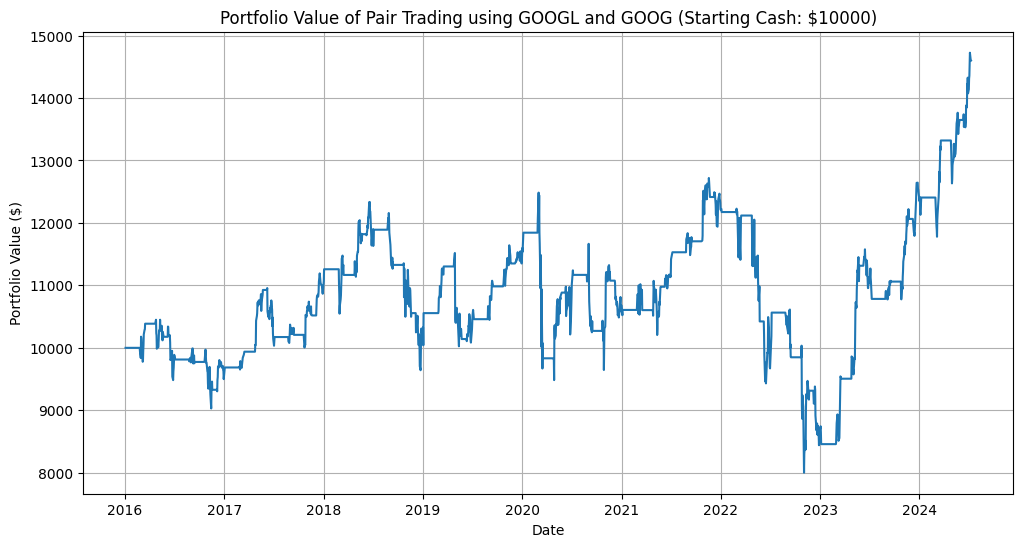

In [36]:
# plot portfolio history
dates = test_prices[max_pair[0]].iloc[IN_SAMPLE_PERIOD:len(values)+IN_SAMPLE_PERIOD].index
plt.figure(figsize=(12, 6))
plt.plot(dates, np.array(values))
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title(f'Portfolio Value of Pair Trading using {max_pair[0]} and {max_pair[1]} (Starting Cash: ${STARTING_CASH})')
plt.grid()
plt.show()

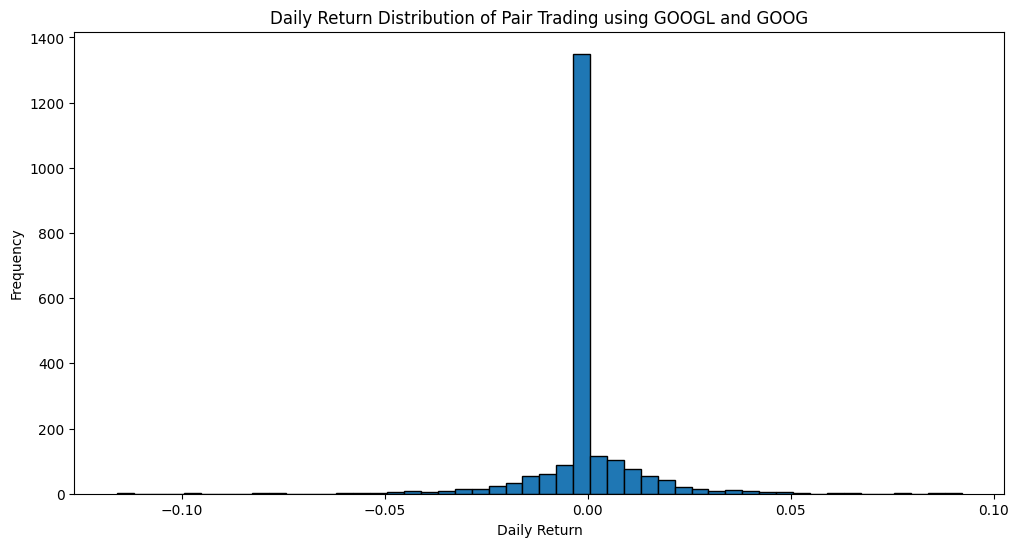

In [37]:
# plot returns distribution
plt.figure(figsize=(12, 6))
plt.hist(returns, bins=50, edgecolor='black')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title(f'Daily Return Distribution of Pair Trading using {max_pair[0]} and {max_pair[1]}')
plt.show()

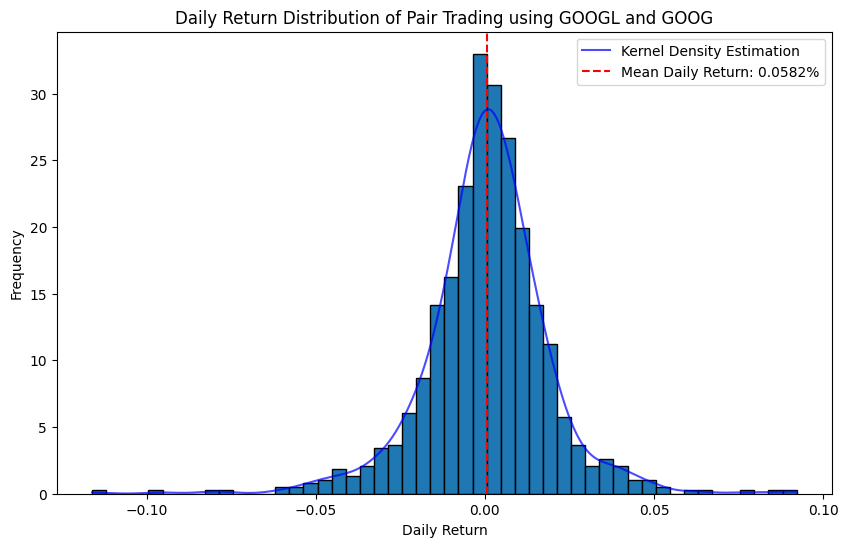

In [67]:
# remove zero returns
nonzero_returns = [r for r in returns if r != 0]
mean_return = np.mean(nonzero_returns)
kde = stats.gaussian_kde(nonzero_returns)
x_values = np.linspace(min(nonzero_returns), max(nonzero_returns), 1000)
kde_values = kde(x_values)

# Plot histogram and KDE
plt.figure(figsize=(10, 6))
plt.hist(nonzero_returns, bins=50, density=True, edgecolor='black')
plt.plot(x_values, kde_values, color='blue', alpha=0.7, label='Kernel Density Estimation')
plt.axvline(mean_return, color='red', linestyle='--', label=f'Mean Daily Return: {100*mean_return:.4f}%')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title(f'Daily Return Distribution of Pair Trading using {max_pair[0]} and {max_pair[1]}')
plt.legend()
plt.show()

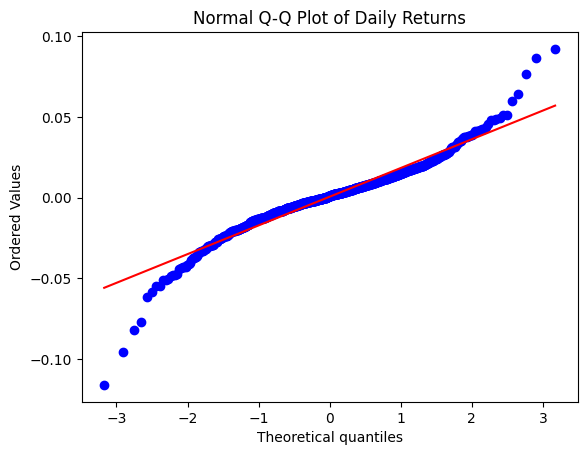

In [69]:
# Q-Q plot
stats.probplot(nonzero_returns, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot of Daily Returns')
plt.show()